In [44]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit
from src.nce.cd_cnce import CdCnceCrit
from src.nce.rank import NceRankCrit
from src.nce.cd_rank import CdRankCrit
from src.nce.per_cnce import PersistentCondNceCrit
from src.nce.per_rank import PersistentNceRankCrit
from src.nce.cd_mh import CdMHCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

from src.experiments.ring_model_exp_utils import get_nce_noise_distr_par, get_cnce_noise_distr_par, generate_true_params, initialise_params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NOISE DISTRIBUTIONS PLOT

In [45]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10, model_class=RingModel):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision, model_class)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


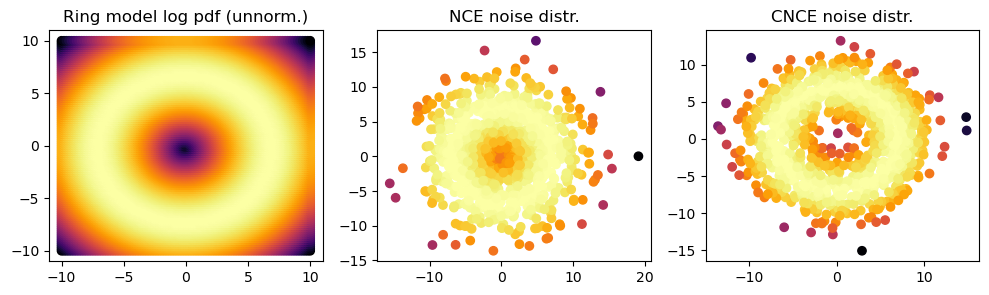

In [46]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
y_samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
y_samples_cnce = sample_cnce(y, num_samples, mu, torch.log(torch.tensor(precision)))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


## EXPERIMENTS

In [47]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5]
reps = 5

# Training specs
batch_size = 32
num_epochs = 5

In [48]:
# An attempt to make things a bit nicer and more versatile

# Configurations to consider in experiments 
config_binary = {
    "criterion": NceBinaryCrit,
    "label": "binary",
    "estimate_part_fn": True,
    "conditional_noise_distr": False,
    "mcmc_steps": None,
}

config_conditional = {
    "criterion": CondNceCrit,
    "label": "conditional",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
}

config_conditional_multi = {
    "criterion": CdCnceCrit,
    "label": "conditional_multi_steps",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 5,
}

config_ranking = {
    "criterion": NceRankCrit,
    "label": "ranking",
    "estimate_part_fn": False,
    "conditional_noise_distr": False,
    "mcmc_steps": None,
}

config_ranking_multi = {
    "criterion": CdRankCrit,
    "label": "ranking_multi_steps",
    "estimate_part_fn": False,
    "conditional_noise_distr": False,
    "mcmc_steps": 5,
}

config_per_cnce = {
    "criterion": PersistentCondNceCrit,
    "label": "persistent_cond_nce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
}

config_per_nce_rank = {
    "criterion": PersistentNceRankCrit,
    "label": "persistent_nce_rank",
    "estimate_part_fn": False,
    "conditional_noise_distr": False,
    "mcmc_steps": None,
}

config_cd_mh = {
    "criterion": CdMHCrit,
    "label": "cd_mh",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 5,
}

configs = [config_binary,
           config_conditional,
           config_conditional_multi,
           config_ranking,
           config_ranking_multi,
           config_per_cnce,
           #config_per_nce_rank,
           config_cd_mh]

In [49]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(configs), reps))

for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init, RingModel)
                        
            for k, config in enumerate(configs):
                
                # Make sure that these are "reinitialised"
                p_m, p_n, criterion = None, None, None
                
                if config["estimate_part_fn"]:
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init.clone(), log_part_fn=log_z_init.clone())
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init.clone())
                    
                if config["conditional_noise_distr"]:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                                        
                if config["mcmc_steps"] is not None:
                    criterion = config["criterion"](p_m, p_n, J, config["mcmc_steps"])
                else:
                    criterion = config["criterion"](p_m, p_n, J)
                
                save_dir = None
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)
                

np.save("res/final_param_error_ring_model_all", error_res)

Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished t

ValueError: Expected parameter probs (Tensor of shape (5,)) of distribution Categorical(probs: torch.Size([5])) to satisfy the constraint Simplex(), but found invalid values:
tensor([0., nan, 0., 0., 0.], dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

In [ ]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']#, 'C8', 'C9']
assert len(colors) == len(configs), "Need one colour for each method"

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, config in enumerate(configs):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), config["label"], colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()